In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [3]:
flight_data = sns.load_dataset("flights")
flight_data.head()
flight_data.shape

(144, 3)

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

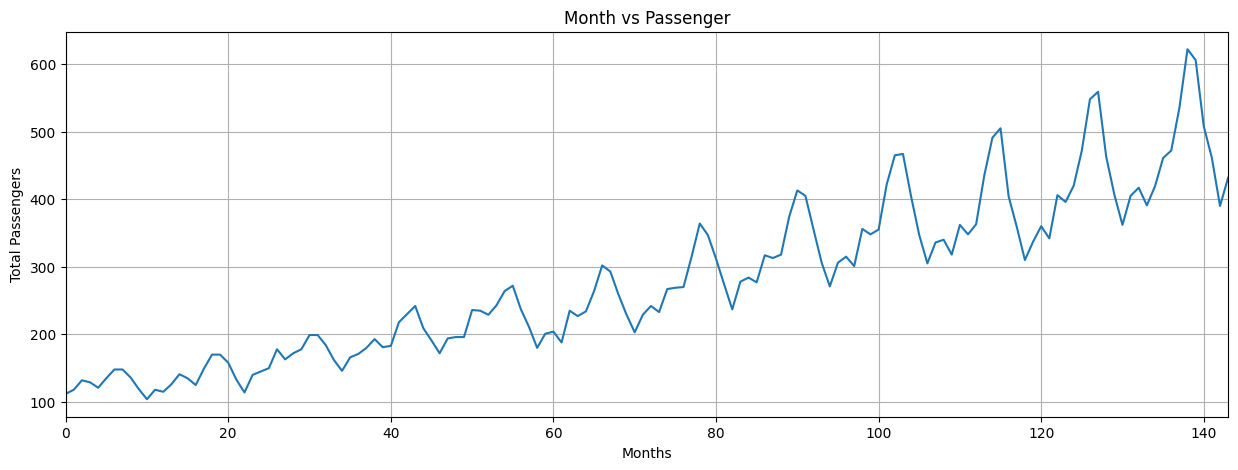

In [5]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [6]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [7]:
all_data = flight_data['passengers'].values.astype(float)

In [8]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [9]:
print(len(train_data))
print(len(test_data))

132
12


In [10]:
print(test_data)

[417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [12]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


In [19]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385, -0.9516, -0.9033, -0.8374, -0.8637,
        -0.9077, -0.8022, -0.7099, -0.7099, -0.7626, -0.8725, -0.9560, -0.8418,
        -0.8198, -0.7978, -0.6747, -0.7407, -0.7011, -0.6747, -0.5824, -0.5824,
        -0.6484, -0.7451, -0.8154, -0.7275, -0.7055, -0.6659, -0.6088, -0.6615,
        -0.6527, -0.4989, -0.4462, -0.3934, -0.5385, -0.6176, -0.7011, -0.6044,
        -0.5956, -0.5956, -0.4198, -0.4242, -0.4505, -0.3890, -0.2967, -0.2615,
        -0.4154, -0.5297, -0.6659, -0.5736, -0.5604, -0.6308, -0.4242, -0.4593,
        -0.4286, -0.2967, -0.1297, -0.1692, -0.3187, -0.4505, -0.5648, -0.4505,
        -0.3934, -0.4330, -0.2835, -0.2747, -0.2703, -0.0725,  0.1429,  0.0681,
        -0.0857, -0.2527, -0.4154, -0.2352, -0.2088, -0.2396, -0.0637, -0.0813,
        -0.0593,  0.1868,  0.3582,  0.3231,  0.1033, -0.1121, -0.2659, -0.1121,
        -0.0725, -0.1341,  0.1077,  0.07

In [14]:
train_window = 12

In [16]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [17]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [18]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

In [108]:
torch.zeros(1,1,10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [110]:
seq, label = train_inout_seq[0]
seq

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])

In [126]:
type(seq)

torch.Tensor

In [120]:
a=seq.view(len(seq), 1 , -1)  #-1 so that numbe rof elements in view matches the original numbe rof elements
a

tensor([[[-0.9648]],

        [[-0.9385]],

        [[-0.8769]],

        [[-0.8901]],

        [[-0.9253]],

        [[-0.8637]],

        [[-0.8066]],

        [[-0.8066]],

        [[-0.8593]],

        [[-0.9341]],

        [[-1.0000]],

        [[-0.9385]]])

In [117]:
b=torch.reshape(seq, (len(seq), 1,1 ))

In [142]:
class LSTM(nn.Module):
    #HIDDEN LAYER SIZE WAS 100 initially
    def __init__(self, input_size=1, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        
       # arr= lstm_out.detach().numpy()
        #print("lstm_out: ", arr)
       # print(type(arr))
        print ("LSTM: ", lstm_out)
        lstm_out_reshaped = lstm_out.view(len(input_seq), -1)
        print ("RESHAPED: ", lstm_out_reshaped)
        print()
       # print (self.hidden_cell)
        #lstm_df= pd.DataFrame(arr)
        #print (lstm_out)
       # lstm_df.to_csv("test.csv")
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [143]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [144]:
print(model)

LSTM(
  (lstm): LSTM(1, 10)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [145]:
epochs = 2 #150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    print()
    #if i%25 == 1:
    #    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

#print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

LSTM:  tensor([[[-2.3105e-02,  7.2292e-02,  1.6736e-02,  8.6749e-02,  7.4668e-02,
          -5.7889e-02,  1.0426e-01,  8.3085e-02, -6.6258e-02,  1.3632e-01]],

        [[-3.0789e-02,  8.6956e-02,  1.3151e-02,  1.2242e-01,  1.1609e-01,
          -9.4105e-02,  1.5692e-01,  1.0406e-01, -8.0831e-02,  2.1794e-01]],

        [[-3.1703e-02,  8.4737e-02,  7.8892e-03,  1.3395e-01,  1.3858e-01,
          -1.1493e-01,  1.7780e-01,  1.0558e-01, -7.6940e-02,  2.5714e-01]],

        [[-3.3274e-02,  8.3444e-02,  3.7172e-03,  1.4051e-01,  1.4860e-01,
          -1.2749e-01,  1.8677e-01,  1.0561e-01, -7.3462e-02,  2.7648e-01]],

        [[-3.5727e-02,  8.4546e-02,  7.1744e-05,  1.4638e-01,  1.5215e-01,
          -1.3566e-01,  1.9155e-01,  1.0704e-01, -7.2825e-02,  2.8717e-01]],

        [[-3.3773e-02,  8.0976e-02, -1.1708e-03,  1.4402e-01,  1.5584e-01,
          -1.3918e-01,  1.9119e-01,  1.0464e-01, -6.6939e-02,  2.8975e-01]],

        [[-3.0372e-02,  7.6180e-02, -1.0888e-04,  1.3826e-01,  1.5875e-01,


LSTM:  tensor([[[-0.0118,  0.0552,  0.0061,  0.0967,  0.0899, -0.0453,  0.1150,
           0.0653, -0.0771,  0.1183]],

        [[-0.0108,  0.0543, -0.0004,  0.1365,  0.1530, -0.0692,  0.1721,
           0.0697, -0.0999,  0.1843]],

        [[-0.0080,  0.0420, -0.0035,  0.1516,  0.1951, -0.0804,  0.1940,
           0.0596, -0.1033,  0.2146]],

        [[-0.0087,  0.0338, -0.0041,  0.1618,  0.2201, -0.0863,  0.2026,
           0.0519, -0.1057,  0.2292]],

        [[-0.0122,  0.0312, -0.0050,  0.1734,  0.2339, -0.0906,  0.2077,
           0.0491, -0.1117,  0.2384]],

        [[-0.0186,  0.0347, -0.0088,  0.1901,  0.2399, -0.0952,  0.2140,
           0.0514, -0.1238,  0.2474]],

        [[-0.0244,  0.0394, -0.0146,  0.2066,  0.2434, -0.0993,  0.2201,
           0.0547, -0.1365,  0.2555]],

        [[-0.0219,  0.0344, -0.0159,  0.2059,  0.2519, -0.0987,  0.2181,
           0.0498, -0.1329,  0.2555]],

        [[-0.0203,  0.0311, -0.0150,  0.2044,  0.2561, -0.0976,  0.2159,
           0.046

LSTM:  tensor([[[ 3.8863e-03,  3.1108e-02,  3.9853e-03,  8.4182e-02,  1.0350e-01,
          -3.2171e-02,  1.1368e-01,  4.4262e-02, -6.7840e-02,  9.6717e-02]],

        [[ 2.6698e-03,  3.1311e-02, -6.6489e-03,  1.4180e-01,  1.7858e-01,
          -5.0987e-02,  1.8224e-01,  4.5892e-02, -1.1153e-01,  1.5755e-01]],

        [[-1.9161e-03,  2.5224e-02, -1.7978e-02,  1.8429e-01,  2.3099e-01,
          -6.1092e-02,  2.1933e-01,  3.7847e-02, -1.4317e-01,  1.9243e-01]],

        [[-1.9483e-03,  1.2484e-02, -2.2220e-02,  2.0333e-01,  2.7070e-01,
          -6.2887e-02,  2.3234e-01,  2.3582e-02, -1.5422e-01,  2.0696e-01]],

        [[-2.8987e-03,  3.0893e-03, -2.2213e-02,  2.1515e-01,  2.9615e-01,
          -6.2075e-02,  2.3627e-01,  1.2747e-02, -1.6094e-01,  2.1314e-01]],

        [[-3.0394e-03, -4.6951e-03, -1.9603e-02,  2.2022e-01,  3.1360e-01,
          -5.9881e-02,  2.3501e-01,  4.0562e-03, -1.6263e-01,  2.1475e-01]],

        [[-1.8958e-03, -1.1923e-02, -1.5031e-02,  2.1938e-01,  3.2578e-01,


LSTM:  tensor([[[ 8.4420e-03,  2.4109e-02,  2.5585e-04,  8.5672e-02,  1.1014e-01,
          -2.7369e-02,  1.1818e-01,  3.7324e-02, -7.0379e-02,  8.9901e-02]],

        [[ 1.9329e-02,  5.9162e-03, -2.8964e-03,  1.2032e-01,  1.9722e-01,
          -3.6410e-02,  1.7587e-01,  2.3159e-02, -9.4842e-02,  1.3595e-01]],

        [[ 2.0277e-02, -1.0298e-02, -3.6448e-03,  1.4634e-01,  2.5643e-01,
          -3.9598e-02,  2.0428e-01,  6.2032e-03, -1.1362e-01,  1.6018e-01]],

        [[ 1.6946e-02, -2.1527e-02, -3.4282e-03,  1.6843e-01,  2.9593e-01,
          -4.0157e-02,  2.1864e-01, -6.8273e-03, -1.2977e-01,  1.7376e-01]],

        [[ 1.6074e-02, -3.2981e-02, -5.0519e-04,  1.7867e-01,  3.2481e-01,
          -3.7210e-02,  2.2118e-01, -1.9853e-02, -1.3532e-01,  1.7882e-01]],

        [[ 1.7628e-02, -4.4452e-02,  5.5141e-03,  1.7847e-01,  3.4523e-01,
          -3.2016e-02,  2.1563e-01, -3.2117e-02, -1.3210e-01,  1.7816e-01]],

        [[ 1.8136e-02, -5.2444e-02,  1.1953e-02,  1.7675e-01,  3.5701e-01,


LSTM:  tensor([[[ 0.0141,  0.0159,  0.0056,  0.0706,  0.1099, -0.0242,  0.1084,
           0.0316, -0.0567,  0.0843]],

        [[ 0.0153,  0.0113, -0.0023,  0.1251,  0.1913, -0.0387,  0.1763,
           0.0284, -0.0997,  0.1379]],

        [[ 0.0181, -0.0065, -0.0052,  0.1500,  0.2531, -0.0416,  0.2045,
           0.0097, -0.1161,  0.1626]],

        [[ 0.0185, -0.0220, -0.0028,  0.1636,  0.2946, -0.0399,  0.2139,
          -0.0073, -0.1238,  0.1731]],

        [[ 0.0150, -0.0301, -0.0007,  0.1786,  0.3197, -0.0387,  0.2190,
          -0.0168, -0.1345,  0.1798]],

        [[ 0.0179, -0.0427,  0.0060,  0.1753,  0.3416, -0.0329,  0.2117,
          -0.0302, -0.1279,  0.1783]],

        [[ 0.0178, -0.0499,  0.0124,  0.1743,  0.3520, -0.0294,  0.2054,
          -0.0370, -0.1255,  0.1768]],

        [[ 0.0171, -0.0540,  0.0174,  0.1741,  0.3582, -0.0272,  0.2003,
          -0.0407, -0.1242,  0.1760]],

        [[ 0.0239, -0.0649,  0.0264,  0.1562,  0.3677, -0.0201,  0.1846,
          -0.051

RESHAPED:  tensor([[ 0.0267, -0.0011,  0.0262,  0.0268,  0.1019, -0.0193,  0.0744,  0.0215,
         -0.0170,  0.0748],
        [ 0.0343, -0.0121,  0.0393,  0.0440,  0.1704, -0.0321,  0.1140,  0.0166,
         -0.0249,  0.1192],
        [ 0.0353, -0.0244,  0.0482,  0.0542,  0.2151, -0.0387,  0.1304,  0.0061,
         -0.0269,  0.1428],
        [ 0.0427, -0.0448,  0.0610,  0.0415,  0.2478, -0.0351,  0.1209, -0.0125,
         -0.0099,  0.1464],
        [ 0.0495, -0.0632,  0.0761,  0.0224,  0.2665, -0.0285,  0.1010, -0.0278,
          0.0098,  0.1411],
        [ 0.0489, -0.0714,  0.0875,  0.0152,  0.2723, -0.0269,  0.0882, -0.0316,
          0.0178,  0.1387],
        [ 0.0398, -0.0661,  0.0906,  0.0292,  0.2696, -0.0332,  0.0924, -0.0237,
          0.0079,  0.1456],
        [ 0.0290, -0.0539,  0.0851,  0.0559,  0.2667, -0.0422,  0.1083, -0.0130,
         -0.0121,  0.1584],
        [ 0.0203, -0.0415,  0.0741,  0.0851,  0.2669, -0.0501,  0.1281, -0.0049,
         -0.0345,  0.1719],
        

LSTM:  tensor([[[ 0.0380, -0.0144,  0.0528, -0.0130,  0.0899, -0.0186,  0.0384,
           0.0145,  0.0183,  0.0706]],

        [[ 0.0395, -0.0149,  0.0811, -0.0033,  0.1397, -0.0410,  0.0684,
           0.0221,  0.0192,  0.1220]],

        [[ 0.0319, -0.0111,  0.0922,  0.0175,  0.1662, -0.0595,  0.0924,
           0.0269,  0.0118,  0.1586]],

        [[ 0.0331, -0.0189,  0.1006,  0.0181,  0.1854, -0.0672,  0.0951,
           0.0199,  0.0203,  0.1742]],

        [[ 0.0333, -0.0243,  0.1072,  0.0173,  0.1943, -0.0714,  0.0930,
           0.0154,  0.0273,  0.1815]],

        [[ 0.0296, -0.0228,  0.1093,  0.0250,  0.1965, -0.0764,  0.0963,
           0.0172,  0.0252,  0.1887]],

        [[ 0.0352, -0.0312,  0.1147,  0.0134,  0.2024, -0.0749,  0.0857,
           0.0096,  0.0375,  0.1859]],

        [[ 0.0346, -0.0321,  0.1185,  0.0120,  0.2010, -0.0759,  0.0823,
           0.0100,  0.0404,  0.1859]],

        [[ 0.0367, -0.0353,  0.1225,  0.0058,  0.2013, -0.0752,  0.0759,
           0.007

LSTM:  tensor([[[-0.0122,  0.0532,  0.0144,  0.0985,  0.0820, -0.0497,  0.1114,
           0.0662, -0.0798,  0.1290]],

        [[-0.0167,  0.0599,  0.0021,  0.1594,  0.1371, -0.0768,  0.1771,
           0.0760, -0.1219,  0.2049]],

        [[-0.0164,  0.0521, -0.0091,  0.1882,  0.1756, -0.0905,  0.2044,
           0.0692, -0.1377,  0.2412]],

        [[-0.0175,  0.0465, -0.0170,  0.2076,  0.1999, -0.0974,  0.2165,
           0.0630, -0.1487,  0.2587]],

        [[-0.0169,  0.0405, -0.0193,  0.2148,  0.2168, -0.1002,  0.2184,
           0.0567, -0.1506,  0.2657]],

        [[-0.0149,  0.0348, -0.0157,  0.2129,  0.2277, -0.1011,  0.2142,
           0.0511, -0.1455,  0.2675]],

        [[-0.0156,  0.0335, -0.0127,  0.2151,  0.2319, -0.1020,  0.2125,
           0.0497, -0.1453,  0.2690]],

        [[-0.0174,  0.0346, -0.0128,  0.2211,  0.2337, -0.1031,  0.2136,
           0.0503, -0.1493,  0.2710]],

        [[-0.0144,  0.0303, -0.0079,  0.2136,  0.2378, -0.1029,  0.2078,
           0.046

LSTM:  tensor([[[-0.0129,  0.0352,  0.0072,  0.0821,  0.0902, -0.0342,  0.1050,
           0.0513, -0.0678,  0.1093]],

        [[-0.0213,  0.0336, -0.0083,  0.1356,  0.1558, -0.0485,  0.1694,
           0.0539, -0.1080,  0.1702]],

        [[-0.0319,  0.0279, -0.0305,  0.1810,  0.2034, -0.0529,  0.2091,
           0.0477, -0.1447,  0.2016]],

        [[-0.0440,  0.0240, -0.0562,  0.2250,  0.2399, -0.0520,  0.2377,
           0.0416, -0.1839,  0.2177]],

        [[-0.0549,  0.0207, -0.0821,  0.2644,  0.2705, -0.0477,  0.2589,
           0.0356, -0.2214,  0.2254]],

        [[-0.0583,  0.0124, -0.0965,  0.2819,  0.2983, -0.0406,  0.2651,
           0.0256, -0.2386,  0.2261]],

        [[-0.0610,  0.0064, -0.1033,  0.2932,  0.3171, -0.0344,  0.2667,
           0.0184, -0.2506,  0.2252]],

        [[-0.0619,  0.0014, -0.1041,  0.2974,  0.3306, -0.0293,  0.2642,
           0.0127, -0.2555,  0.2237]],

        [[-0.0608, -0.0033, -0.0995,  0.2947,  0.3396, -0.0254,  0.2579,
           0.007

LSTM:  tensor([[[-0.0195,  0.0363, -0.0028,  0.0932,  0.0942, -0.0308,  0.1142,
           0.0509, -0.0795,  0.1080]],

        [[-0.0332,  0.0332, -0.0291,  0.1568,  0.1674, -0.0406,  0.1874,
           0.0515, -0.1320,  0.1667]],

        [[-0.0458,  0.0227, -0.0568,  0.2037,  0.2239, -0.0401,  0.2294,
           0.0410, -0.1732,  0.1947]],

        [[-0.0484,  0.0057, -0.0671,  0.2170,  0.2682, -0.0334,  0.2388,
           0.0245, -0.1849,  0.2036]],

        [[-0.0540, -0.0033, -0.0712,  0.2301,  0.2951, -0.0277,  0.2427,
           0.0155, -0.1978,  0.2073]],

        [[-0.0605, -0.0080, -0.0749,  0.2442,  0.3133, -0.0233,  0.2460,
           0.0106, -0.2115,  0.2094]],

        [[-0.0619, -0.0137, -0.0736,  0.2476,  0.3276, -0.0187,  0.2422,
           0.0046, -0.2145,  0.2092]],

        [[-0.0590, -0.0200, -0.0647,  0.2395,  0.3366, -0.0147,  0.2311,
          -0.0013, -0.2062,  0.2074]],

        [[-0.0565, -0.0238, -0.0529,  0.2299,  0.3390, -0.0133,  0.2196,
          -0.004

LSTM:  tensor([[[ 0.0037,  0.0134,  0.0295,  0.0337,  0.0881, -0.0283,  0.0727,
           0.0366, -0.0244,  0.0952]],

        [[-0.0009,  0.0106,  0.0370,  0.0602,  0.1445, -0.0436,  0.1179,
           0.0404, -0.0387,  0.1510]],

        [[-0.0137,  0.0102,  0.0274,  0.0975,  0.1814, -0.0515,  0.1541,
           0.0401, -0.0645,  0.1837]],

        [[-0.0283,  0.0106,  0.0056,  0.1413,  0.2107, -0.0532,  0.1860,
           0.0383, -0.1001,  0.2023]],

        [[-0.0426,  0.0110, -0.0240,  0.1878,  0.2381, -0.0504,  0.2152,
           0.0351, -0.1427,  0.2123]],

        [[-0.0461,  0.0025, -0.0419,  0.2067,  0.2668, -0.0431,  0.2246,
           0.0246, -0.1618,  0.2135]],

        [[-0.0476, -0.0052, -0.0492,  0.2150,  0.2878, -0.0358,  0.2253,
           0.0159, -0.1719,  0.2120]],

        [[-0.0520, -0.0080, -0.0550,  0.2274,  0.3016, -0.0309,  0.2284,
           0.0122, -0.1860,  0.2115]],

        [[-0.0479, -0.0158, -0.0489,  0.2182,  0.3146, -0.0252,  0.2175,
           0.004

LSTM:  tensor([[[ 1.3162e-02,  8.7421e-03,  4.2891e-02,  1.8072e-02,  8.2590e-02,
          -3.2036e-02,  5.7628e-02,  3.4952e-02, -7.7808e-03,  9.5656e-02]],

        [[ 1.5291e-02,  5.1478e-03,  6.5732e-02,  2.8848e-02,  1.2981e-01,
          -5.2359e-02,  8.7964e-02,  3.9615e-02, -4.1241e-03,  1.5253e-01]],

        [[ 1.4826e-02, -8.2143e-04,  8.1107e-02,  3.2206e-02,  1.5493e-01,
          -6.5128e-02,  9.8420e-02,  3.6961e-02,  5.4942e-03,  1.8337e-01]],

        [[ 2.3756e-02, -1.4471e-02,  1.0649e-01,  7.5679e-03,  1.6646e-01,
          -7.2841e-02,  7.9781e-02,  2.7558e-02,  3.7204e-02,  1.9515e-01]],

        [[ 3.3741e-02, -2.5792e-02,  1.3840e-01, -2.4919e-02,  1.6355e-01,
          -8.0243e-02,  5.0269e-02,  2.1552e-02,  7.3472e-02,  1.9864e-01]],

        [[ 3.6490e-02, -2.7667e-02,  1.6304e-01, -4.3223e-02,  1.5066e-01,
          -8.9219e-02,  3.1878e-02,  2.4440e-02,  9.6987e-02,  2.0225e-01]],

        [[ 2.9909e-02, -1.8328e-02,  1.6931e-01, -3.5757e-02,  1.3578e-01,


LSTM:  tensor([[[ 0.0210,  0.0057,  0.0588,  0.0077,  0.0764, -0.0416,  0.0473,
           0.0372,  0.0047,  0.1051]],

        [[ 0.0378, -0.0064,  0.1111, -0.0133,  0.1124, -0.0713,  0.0506,
           0.0388,  0.0423,  0.1658]],

        [[ 0.0415, -0.0095,  0.1494, -0.0250,  0.1197, -0.0955,  0.0483,
           0.0418,  0.0726,  0.2033]],

        [[ 0.0464, -0.0131,  0.1816, -0.0421,  0.1135, -0.1150,  0.0362,
           0.0428,  0.1045,  0.2247]],

        [[ 0.0621, -0.0253,  0.2225, -0.0815,  0.0987, -0.1324,  0.0011,
           0.0372,  0.1483,  0.2324]],

        [[ 0.0785, -0.0369,  0.2668, -0.1219,  0.0750, -0.1494, -0.0390,
           0.0336,  0.1874,  0.2341]],

        [[ 0.0885, -0.0416,  0.3031, -0.1496,  0.0474, -0.1653, -0.0679,
           0.0363,  0.2147,  0.2362]],

        [[ 0.0796, -0.0243,  0.3123, -0.1434,  0.0221, -0.1744, -0.0596,
           0.0540,  0.2248,  0.2474]],

        [[ 0.0705, -0.0063,  0.3063, -0.1262,  0.0050, -0.1811, -0.0379,
           0.066

In [103]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [ ]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [ ]:
test_inputs[fut_pred:]

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

In [ ]:
x = np.arange(132, 144, 1)
print(x)

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()